# EigenFaces

Before we begin, ask a friend to take a picture of you from a distance of around 1m with the default focus of ypour phone. Then, crop the image on your computer so it would contain only your face with a bit of a background. Save it with the name of "me" and locate it within the empty folder called "Data". Do not change the orders of folders. Keep the same order as in the zip file of HW3. You may also use a face out of the dataset as you would see later on but it is much more impressive if you do it with your face image.

In [1]:
import numpy as np
import itertools
from tqdm import tqdm
import pickle
import sys
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
mpl.style.use(['ggplot']) 
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from IPython.display import display, clear_output

from PIL import Image
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA

We will start by loading a dataset of human faces out of `scikit-learn` datasets.

In [2]:
# Load data
lfw_dataset = fetch_lfw_people(min_faces_per_person=0)
_, h, w = lfw_dataset.images.shape
X = lfw_dataset.data
print("Dataset images are at the shape of {}X{}".format(h,w))

Dataset images are at the shape of 62X47


13,233 images were flattened and stacked in the matrix $X$ so every row is an image and every column is a pixel. We can see that by the shape of $X$.

In [3]:
print(X.shape)

(13233, 2914)


Let's see some of the images of the original dataset:

In [4]:
def plot_gallery(images, h, w,rows=3, cols=4):
    plt.figure(figsize=(10,10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i, :].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.show()

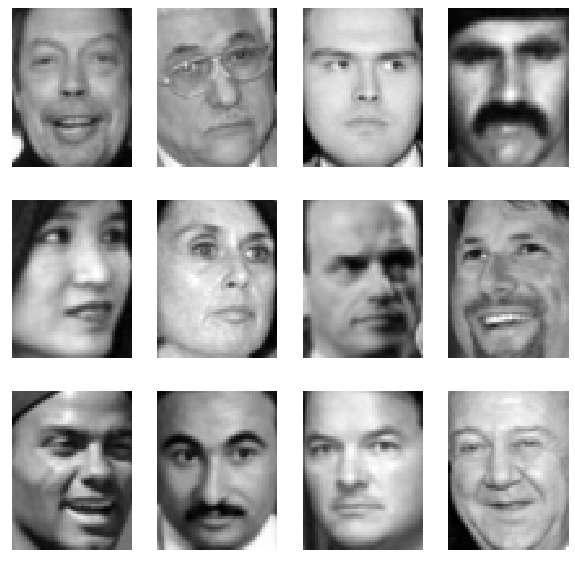

In [5]:
plot_gallery(X[0:12,:], h, w)

Before we use the `PCA` package, we have to center our data. The center of our data ($\mu$) is the mean of each pixel along all of our images. Thus, the center has 2914 elements where the first element is the mean of all of the images' "first" pixels, the second is the mean of all of the images' "second" pixels etc. Notice that the images are already flattened in $X$ which might help you.

Calculate $\mu$ of $X$ and center every image in $X$ (row vector) according to $\mu$. Keep $X$ with same name `X`.

**Bonus**: Applying centering without a single loop would give you extra credit points.

In [6]:
#----------------------------Implement your code here-----------------------
X = X-np.array([np.mean(X, axis=0),]*X.shape[0])
#---------------------------------------------------------------------------

Now fit a PCA model on $X$ with 1000 components and without whitening.

In [7]:
#----------------------------Implement your code here-----------------------
pca = PCA(n_components=1000)
pca.fit(X)
#---------------------------------------------------------------------------

PCA(n_components=1000)

---

<span style="color:red">***Question:***</span> *If we now have 1000 eigenvectors, by how many dimensions we have reduced our data?*

---

---

<span style="color:red">***Answer:***</span> If we have now 1000 eigenvectors, knowing that the original dimension of our data was 62*47 = 2914, it means we reduced our data by 2914-1000 = 1914 dimensions

---

Calculate the precentage of "energy" preserved in these 1000 vectors.

In [8]:
#----------------------------Implement your code here-----------------------
pca2 = PCA(n_components=X.shape[1])
pca2.fit(X)

energy_reduced = np.sum(pca.explained_variance_)
energy_all = np.sum(pca2.explained_variance_)
print(f'The percentage of energy preserved in the 1000 vectors is: {energy_reduced/energy_all}')
#---------------------------------------------------------------------------

The percentage of energy preserved in the 1000 vectors is: 0.9976417422294617


Let's see these eigenfaces!

In [9]:
def plot_eigenfaces(eigenvec_mat, h, w, rows=3, cols=4):
    plt.figure(figsize=(10,10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(eigenvec_mat[i, :].reshape((h, w)), cmap=plt.cm.gray)
        plt.title("$u_{" + str(i+1) + "}$")
        plt.xticks(())
        plt.yticks(())
    plt.show()

`eigenvec_mat` is the matrix of the eigenvectors calculated where every row is an eigenvector and the first row has the highest eigenvalue and the second row has the next highest eigenvalue etc. Think where this matrix was calculated in the process.

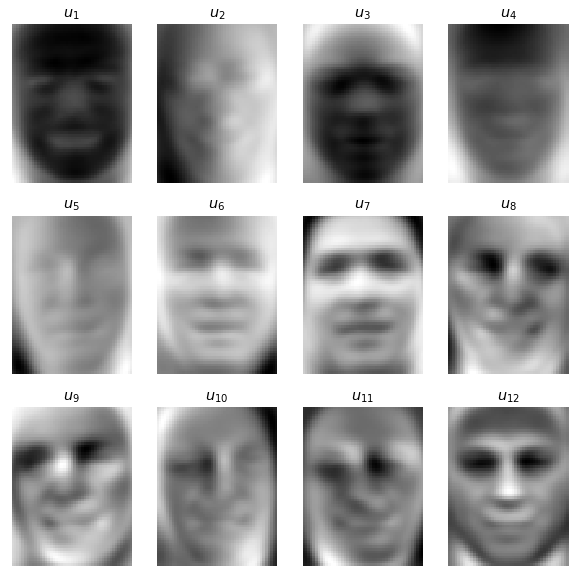

In [10]:
eigenvec_mat = pca.components_
plot_eigenfaces(eigenvec_mat, h, w)

If you got it right, you should see those "ghosts" we talked about.

And now, let's move on towards the more interesting part! We will start by showing your resized gray level face image. It might be a bit distorted due to resizing. Change the format of `.jpg` as needed.

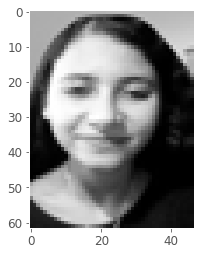

In [11]:
img_format = '.jpg' # change the format according to your image. Do not delete the dot sign before the format name
image = Image.open('Data/me' + img_format)
gray = image.convert('L')
g = gray.resize((w, h))
orig = np.asarray(g).astype('float32')
plt.imshow(orig, cmap=plt.cm.gray)
plt.grid(False)

Now we should flatten our image and center it by the same $\mu$ vector you calculated before. Name the $\mu$ vector as `mu_orig`. If you don't want\can't use your image, or if you just want to have a sanity check, you can run the two lines (shown in comment) instead of the one above in the next cell.

In [12]:
flattened_img = np.asarray(g).astype('float32').flatten()
mu_orig = np.mean(flattened_img, axis=0)
# flattened_img = X[50] + mu_orig
# orig = flattened_img.reshape((h, w))


In [13]:
flattened_img -= mu_orig

Set `K` to be 900 and define `U` to be the matrix containing the first K eigenvectors (rows) extracted from `eigenvec_mat`. Now, calculate the projections $c_i$ so you would have a vector with $K$ elements where the first element is $c_1$ and the second is $c_2$ etc. Relate to the pdf if you are not sure.

In [14]:
#----------------------------Implement your code here-----------------------
K = 900
U = eigenvec_mat[:900]
c = U @ flattened_img
#--------------------------------------------------------------------------

If you got it all correct, then the cell below will show you how your face is reconstructed as a linear combination of the eigenfaces which actually means that your face is a linear combination of other people's faces! The coefficients will appear with their adequate sign in the title in the left and the image constructed will appear slowly on the right.

Notice the "correction" of the centering made in the loop for visualization.

It might even work with much lower dimension such as K=600. You can try!

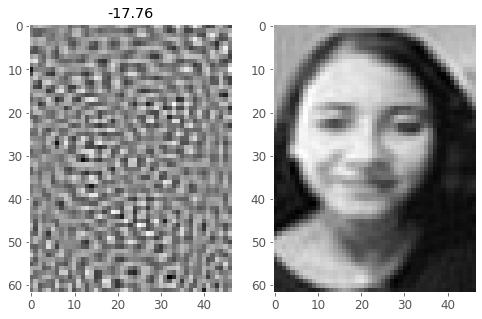

In [15]:
s = np.zeros((2914,))
fig, axes = plt.subplots(1, 2,figsize=(8,8))
for j in range(K):
    s += c[j]*U[j, :]
    if np.mod(j, 10) == 0:
        axes[0].imshow(U[j, :].reshape((h, w)), cmap=plt.cm.gray)
        axes[0].grid(False)
        corrected_image = s + mu_orig
        axes[1].imshow(corrected_image.reshape((h, w)), cmap=plt.cm.gray)
        axes[1].grid(False)
        if c[j] < 0:
            axes[0].set_title('{:.2f}'.format(c[j]))
        else:
            axes[0].set_title('+{:.2f}'.format(c[j]))
        display(fig)
        clear_output(wait = True)
        plt.pause(0.3)
        if c[j] > 0:
            p = '+' + str(c[j])
        else:
            p = str(c[j])

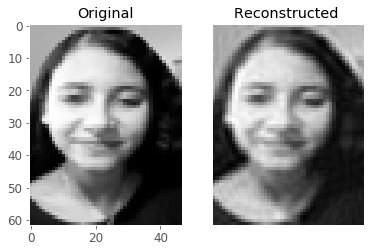

In [16]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(orig, cmap=plt.cm.gray) 
axes[0].title.set_text('Original')
axes[0].grid(False)
plt.xticks(())
plt.yticks(())
axes[1].imshow(corrected_image.reshape((h, w)), cmap=plt.cm.gray)
axes[1].title.set_text('Reconstructed ')
axes[1].grid(False)
plt.xticks(())
plt.yticks(())
plt.show()

Hope you enjoyed :)